In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
from matplotlib.image import imread
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [2]:
# Set some parameters
im_width = 256
im_height = 256
border = 5
path_train = os.path.join( os.getcwd(), 'input',  'train')
path_test = os.path.join( os.getcwd(), 'input',  'test')

In [3]:
# Get and resize train images and masks
def get_data(path, train=True):
    ids = next(os.walk(path + "\images"))[2]
    mask_ids = next(os.walk(path + '\masks'))[2]
    X = np.zeros((len(ids), im_height, im_width, 3), dtype=np.float32)
    if train:
        y = np.zeros((len(mask_ids), im_height, im_width, 3), dtype=np.float32)
    print('Getting and resizing images ... ')
    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
        # Load images
        #img = load_img(path + '/images/' + id_, grayscale=False)
        img = imread(path + '/images/' + id_)
        #(b, g, r)=cv2.split(img)
        #img=cv2.merge([r,g,b])
        x_img = img_to_array(img)
        x_img = resize(x_img, (256, 256, 3), mode='constant', preserve_range=True)
        # Save images
        X[n, ..., 0] = x_img[:,:,0].squeeze() / 255
        X[n, ..., 1] = x_img[:,:,1].squeeze() / 255
        X[n, ..., 2] = x_img[:,:,2].squeeze() / 255
        #X.append(x_img/255)
    for n, id_ in tqdm_notebook(enumerate(mask_ids), total=len(mask_ids)):
    # Load masks


        if train:
            mask = img_to_array(load_img(path + '/masks/' + id_ , grayscale=False))
            mask = resize(mask, (256, 256, 3), mode='constant', preserve_range=True)
        if train:
            y[n] = mask / 255 
    print('Done!')
    if train:
        return X, y
    else:
        return X
    
X, y = get_data(path_train, train=True)

Getting and resizing images ... 



Done!


In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=42)

In [5]:
def plot_img(ix):
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))

    ax[0].imshow(X_train[ix])
    ax[0].set_title('Image')

    ax[1].imshow(y_train[ix])
    ax[1].set_title('mask');

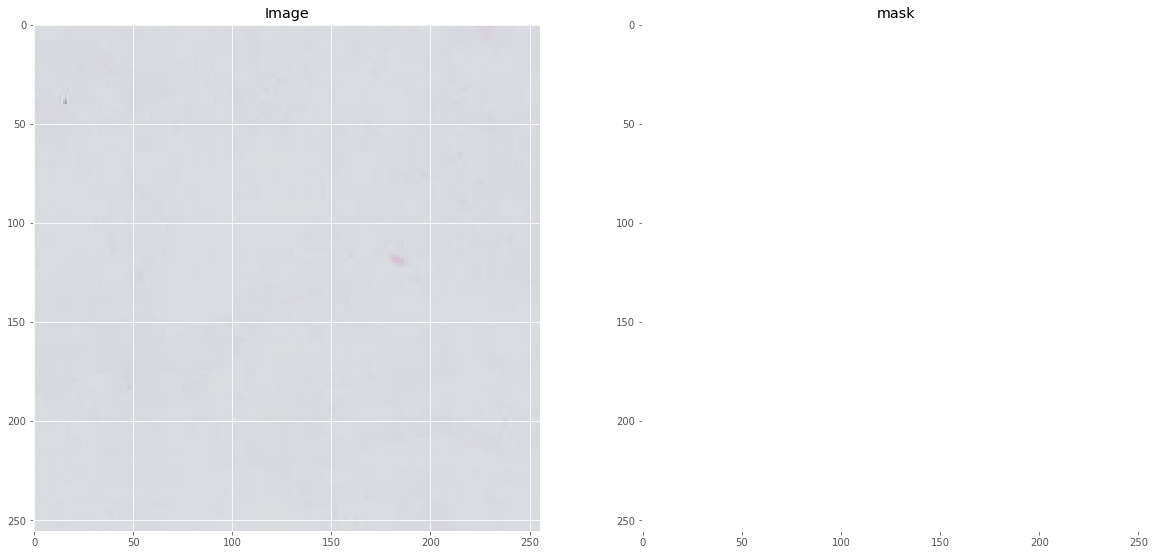

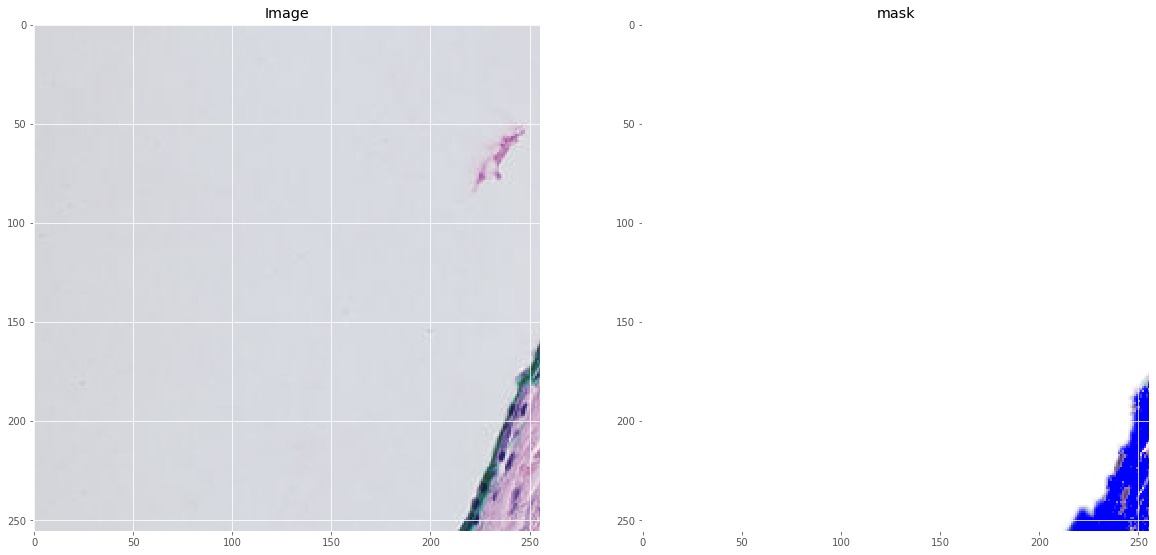

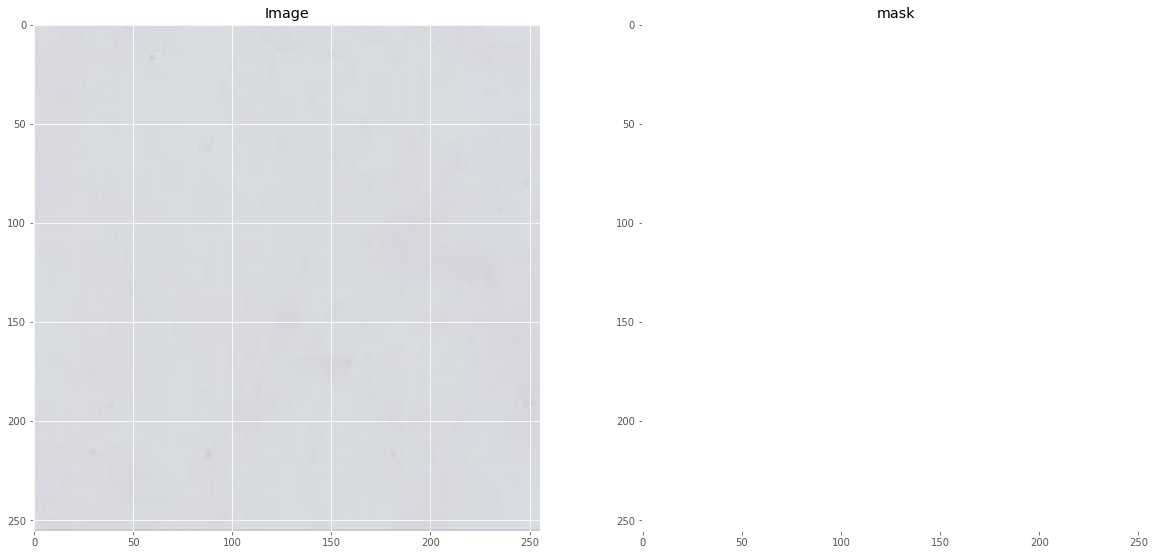

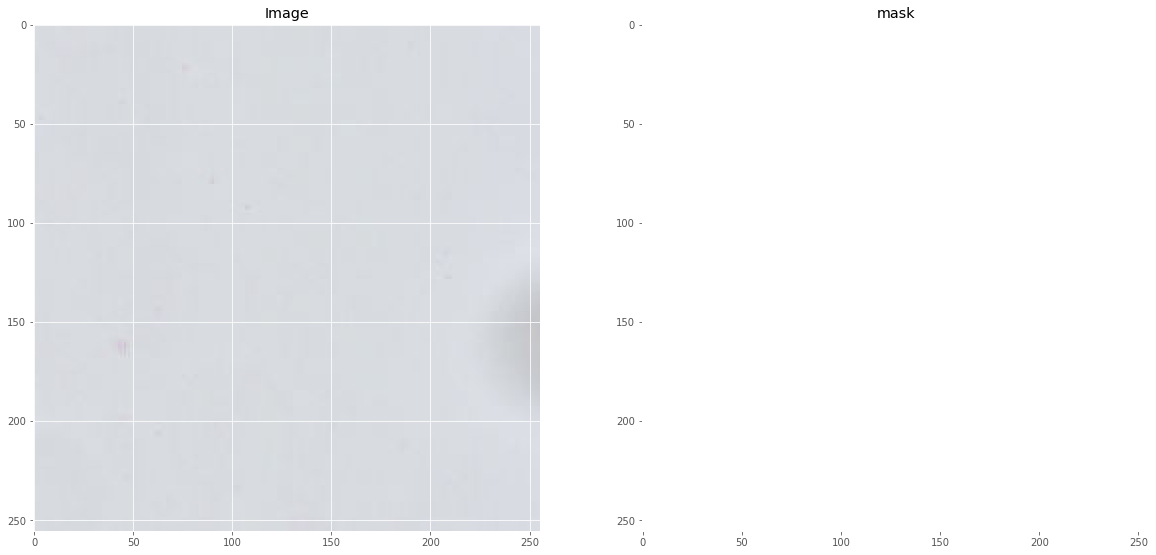

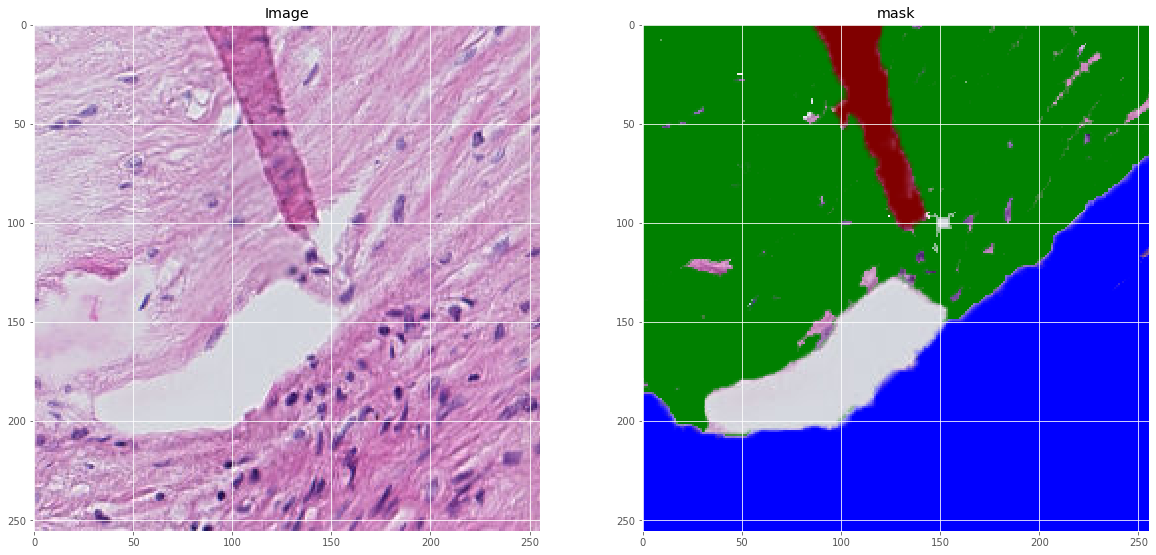

In [6]:
for i in range(0, 5):
    ix = random.randint(0, len(X_train))
    plot_img(ix)


In [7]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [8]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(3, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [9]:
input_img = Input((im_height, im_width, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

W0926 23:26:55.588642  6692 deprecation_wrapper.py:119] From C:\Users\785pa\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0926 23:26:55.661029  6692 deprecation_wrapper.py:119] From C:\Users\785pa\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0926 23:26:55.664798  6692 deprecation_wrapper.py:119] From C:\Users\785pa\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0926 23:26:55.769276  6692 deprecation_wrapper.py:119] From C:\Users\785pa\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0926 23:26:55.772853  6692 deprecation_wrapp

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 16) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 32, 32, 256)  0           conv2d_transpose_1[0][0]         
                                                                 activation_8[0][0]               
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 32, 32, 256)  0           concatenate_1[0][0]              
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 32, 32, 128)  295040      dropout_5[0][0]                  
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, 32, 32, 128)  512         conv2d_11[0][0]                  
__________________________________________________________________________________________________
activation

In [10]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-unet-basic.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [11]:
results = model.fit(X_train, y_train, batch_size=32, epochs=100, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))

W0926 23:27:02.375719  6692 deprecation.py:323] From C:\Users\785pa\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 481 samples, validate on 86 samples
Epoch 1/100
481/481 [==============================] - ETA: 10:03 - loss: 2.7683 - acc: 0.64 - ETA: 7:14 - loss: 2.8148 - acc: 0.5844 - ETA: 6:01 - loss: 2.8668 - acc: 0.532 - ETA: 5:10 - loss: 2.8309 - acc: 0.476 - ETA: 4:22 - loss: 2.8267 - acc: 0.416 - ETA: 3:39 - loss: 2.7735 - acc: 0.388 - ETA: 3:02 - loss: 2.7777 - acc: 0.353 - ETA: 2:33 - loss: 2.8004 - acc: 0.324 - ETA: 2:06 - loss: 2.7811 - acc: 0.309 - ETA: 1:42 - loss: 2.7991 - acc: 0.288 - ETA: 1:20 - loss: 2.7821 - acc: 0.278 - ETA: 58s - loss: 2.7693 - acc: 0.270 - ETA: 38s - loss: 2.7393 - acc: 0.27 - ETA: 19s - loss: 2.7322 - acc: 0.27 - ETA: 0s - loss: 2.7293 - acc: 0.2674 - 301s 626ms/step - loss: 2.7306 - acc: 0.2671 - val_loss: 2.8592 - val_acc: 0.5390

Epoch 00001: val_loss improved from inf to 2.85919, saving model to model-tgs-salt.h5
Epoch 2/100
481/481 [==============================] - ETA: 3:40 - loss: 2.4719 - acc: 0.597 - ETA: 3:20 - loss: 2.5152 - acc: 0.580 - E

481/481 [==============================] - ETA: 3:01 - loss: 2.5726 - acc: 0.674 - ETA: 2:47 - loss: 2.4438 - acc: 0.685 - ETA: 2:34 - loss: 2.5593 - acc: 0.604 - ETA: 2:21 - loss: 2.5180 - acc: 0.618 - ETA: 2:10 - loss: 2.5482 - acc: 0.592 - ETA: 1:57 - loss: 2.5890 - acc: 0.561 - ETA: 1:44 - loss: 2.6263 - acc: 0.512 - ETA: 1:31 - loss: 2.6067 - acc: 0.533 - ETA: 1:18 - loss: 2.6257 - acc: 0.512 - ETA: 1:05 - loss: 2.6527 - acc: 0.477 - ETA: 52s - loss: 2.6383 - acc: 0.490 - ETA: 39s - loss: 2.6562 - acc: 0.47 - ETA: 26s - loss: 2.6362 - acc: 0.49 - ETA: 13s - loss: 2.6363 - acc: 0.49 - ETA: 0s - loss: 2.6424 - acc: 0.4930 - 210s 437ms/step - loss: 2.6438 - acc: 0.4920 - val_loss: 2.7599 - val_acc: 0.7893

Epoch 00011: val_loss improved from 2.76912 to 2.75992, saving model to model-tgs-salt.h5
Epoch 12/100
481/481 [==============================] - ETA: 2:58 - loss: 2.9356 - acc: 0.130 - ETA: 2:46 - loss: 2.7573 - acc: 0.384 - ETA: 2:34 - loss: 2.7225 - acc: 0.455 - ETA: 2:21 - loss

481/481 [==============================] - ETA: 3:20 - loss: 2.5624 - acc: 0.560 - ETA: 2:59 - loss: 2.5871 - acc: 0.536 - ETA: 2:41 - loss: 2.5568 - acc: 0.557 - ETA: 2:26 - loss: 2.6283 - acc: 0.467 - ETA: 2:11 - loss: 2.6399 - acc: 0.454 - ETA: 1:58 - loss: 2.6321 - acc: 0.468 - ETA: 1:44 - loss: 2.6345 - acc: 0.477 - ETA: 1:31 - loss: 2.6691 - acc: 0.442 - ETA: 1:18 - loss: 2.7076 - acc: 0.406 - ETA: 1:05 - loss: 2.6922 - acc: 0.427 - ETA: 52s - loss: 2.6698 - acc: 0.442 - ETA: 39s - loss: 2.6541 - acc: 0.45 - ETA: 26s - loss: 2.6638 - acc: 0.44 - ETA: 13s - loss: 2.6498 - acc: 0.45 - ETA: 0s - loss: 2.6357 - acc: 0.4587 - 213s 443ms/step - loss: 2.6371 - acc: 0.4578 - val_loss: 2.7720 - val_acc: 0.5231

Epoch 00021: val_loss did not improve from 2.75039
Epoch 22/100
481/481 [==============================] - ETA: 2:59 - loss: 2.5824 - acc: 0.590 - ETA: 2:46 - loss: 2.6633 - acc: 0.454 - ETA: 2:34 - loss: 2.5960 - acc: 0.498 - ETA: 2:21 - loss: 2.6158 - acc: 0.484 - ETA: 2:09 - los

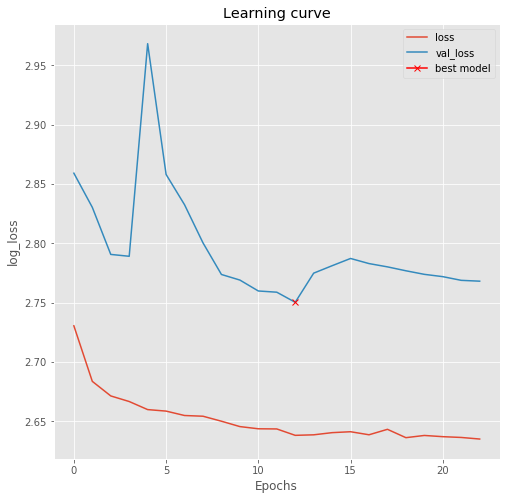

In [12]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [13]:
# Load best model
model.load_weights('model-unet-basic.h5')

In [14]:
model.evaluate(X_valid, y_valid, verbose=1)

86/86 [==============================] - ETA: 10 - ETA: 4 - 17s 195ms/step


[2.7503890824872395, 0.8242703828700754]

In [15]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

86/86 [==============================] - ETA: 10 - ETA: 4 - 18s 204ms/step


In [25]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(X[ix])
   
    ax[0].set_title('Image')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
   
    ax[2].set_title('Mask Predicted')
    


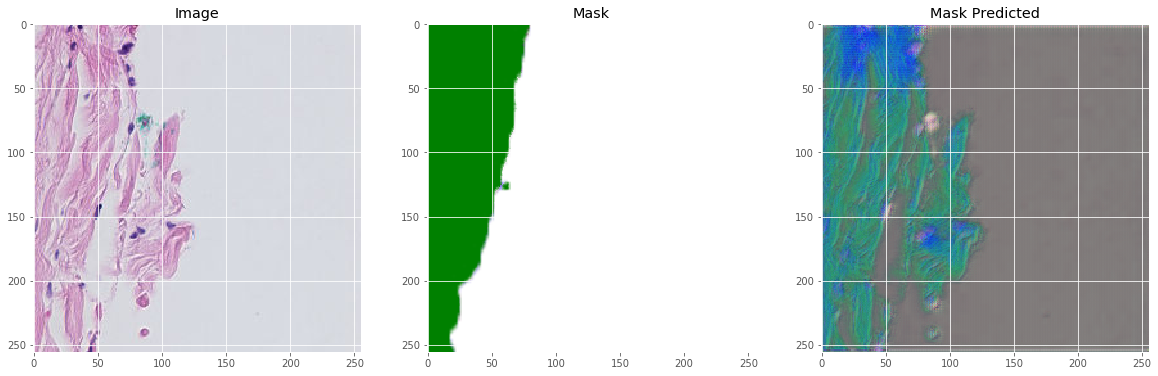

In [26]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=42)

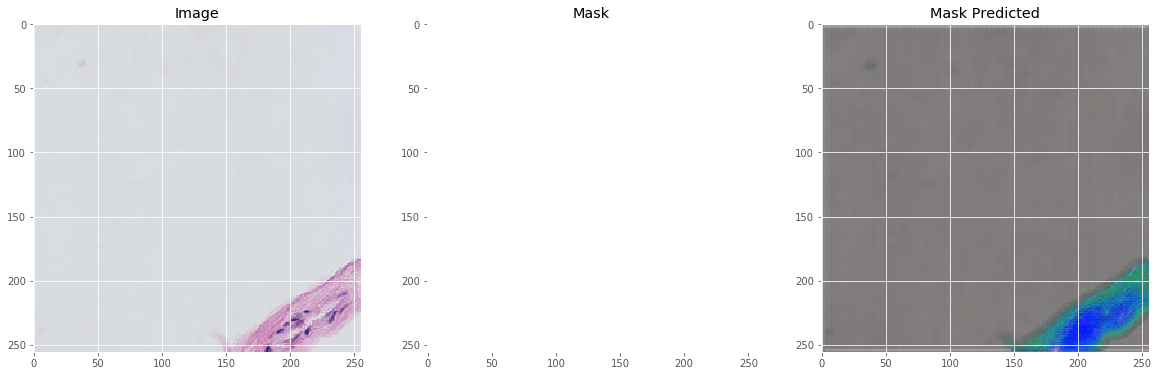

In [28]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=42)